In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import folium
import os
import glob
import random


import scipy.stats as stats


from sklearn.preprocessing import MinMaxScaler, StandardScaler

from numpy import array
import keras
import keras.backend as K
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Bidirectional
from keras.layers import Reshape
from keras.layers import Input
from keras.layers import Dropout
from keras.layers import Concatenate
from keras.layers import RepeatVector

from tensorflow.keras.optimizers import SGD

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score

from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers import Conv1D
from keras.layers import MaxPooling1D

from keras.layers import TimeDistributed, RepeatVector
from tensorflow.keras import layers

import tensorflow as tf
from datetime import datetime
from textwrap import wrap
import itertools

from sklearn.model_selection import train_test_split

2024-12-11 12:37:44.409948: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-11 12:37:44.444605: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-11 12:37:45.329097: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-11 12:37:45.720772: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733881066.580123  187528 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733881066.67

In [3]:
os.chdir(os.path.dirname(os.path.abspath("__file__")))

In [4]:
timeseries_dfs = []
summary_dfs = []

# Read all csv files from directory
# Sort files into timeseries and summary data
for file_path in glob.glob('/srv/scratch/z5370003/data/camels-dropbox/**/*.csv', recursive=True):
    file_name = os.path.splitext(os.path.basename(file_path))[0]
    df = pd.read_csv(file_path, low_memory=False) 

    #skip these files
    if file_name in ['streamflow_QualityCodes']:
        continue

    if 'year' in df.columns:    
        df['source'] = file_name
        df= df[df['year'] > 1990]
        df= df.drop_duplicates(['year','month','day'])
        timeseries_dfs.append(df)
    else:
        df = df.rename({'ID':'station_id'}, axis=1)
        df = df.set_index('station_id')
        summary_dfs.append(df)

timeseries_data = pd.concat(timeseries_dfs, axis=0, ignore_index=True)
timeseries_data['date'] = pd.to_datetime(timeseries_data[['year', 'month', 'day']])
timeseries_data = timeseries_data.drop(['year', 'month', 'day'], axis=1)

summary_data = pd.concat(summary_dfs, axis=1)

In [5]:
class PrepareData():
    def __init__(self, timeseries_data=timeseries_data, summary_data=summary_data):
        ### Data Cleaning
        self.timeseries_data = timeseries_data.replace(-99.99,np.nan)
        
        ### Feature Engineering
        # get precipitation deficit
        actualTransEvap_data = self.timeseries_data[self.timeseries_data['source'] == 'et_morton_actual_SILO'].drop(['source'], axis=1)
        precipitation_data = self.timeseries_data[self.timeseries_data['source'] == 'precipitation_AWAP'].drop(['source'], axis=1)
         
        actualTransEvap_data = actualTransEvap_data[actualTransEvap_data['date'].isin(precipitation_data['date'])].reset_index(drop=True)
        precipitation_data = precipitation_data[precipitation_data['date'].isin(actualTransEvap_data['date'])].reset_index(drop=True)
        
        self.precipitation_deficit = precipitation_data.drop(['date'], axis=1).subtract(actualTransEvap_data.drop(['date'], axis=1))
        self.precipitation_deficit['source'] = 'precipitation_deficit'
        self.precipitation_deficit['date'] = precipitation_data['date']
        
        # get flood probabilities
        self.streamflow_data = self.timeseries_data[timeseries_data['source'] == 'streamflow_MLd_inclInfilled'].drop(['source'], axis=1)
        self.streamflow_data = self.streamflow_data.set_index('date')
        
        self.flood_probabilities = self.streamflow_data.apply(self.flood_extent, axis=0)
        self.flood_probabilities['source'] = 'flood_probabilities'
        self.flood_probabilities['date'] = self.streamflow_data.index
        
        self.flood_indicator = self.flood_probabilities.applymap(lambda x: int(x <0.05) if pd.isnull(x) == False and isinstance(x, float) else x)
        self.flood_indicator['source'] = 'flood_indicator'
        self.flood_indicator['date'] = self.flood_probabilities['date']        
        
        # turn date into sin and cos function 
        date_min = np.min(self.flood_probabilities['date'])
        year_seconds = 365.2425*24*60*60
        year_sin = self.flood_probabilities['date'].apply(lambda x: np.sin((x-date_min).total_seconds() * (2 * np.pi / year_seconds)))
        year_cos = self.flood_probabilities['date'].apply(lambda x: np.cos((x-date_min).total_seconds() * (2 * np.pi / year_seconds)))
        all_stations = list(self.flood_probabilities.drop(columns=['source', 'date'], axis=1).columns) 
        
        df_sin = []     
        for value in year_sin:
            df_sin.append({k:value for k in all_stations})
            
        df_sin = pd.DataFrame(df_sin)
        df_sin['source'] = 'year_sin'
        df_sin['date'] = self.flood_probabilities['date']
 
        df_cos = []
        for value in year_cos:
            df_cos.append({k:value for k in all_stations})
            
        df_cos = pd.DataFrame(df_cos)
        df_cos['source'] = 'year_cos'
        df_cos['date'] = self.flood_probabilities['date']
            
        ### Return
        self.timeseries_data = pd.concat([self.timeseries_data, self.precipitation_deficit, self.flood_probabilities, df_sin, df_cos, self.flood_indicator], axis=0).reset_index(drop=True)
        self.summary_data = summary_data
        
    def get_timeseries_data(self, source, stations):      
        # filter by source
        self.data_filtered = self.timeseries_data[self.timeseries_data['source'].isin(source)]
        # pivot data by station
        self.data_filtered = self.data_filtered[['date', 'source'] + stations].pivot(index='date', columns='source', values=stations)
        # get rows with no nan
        self.data_filtered = self.data_filtered[~self.data_filtered.isnull().any(axis=1)]
        
        return self.data_filtered
        
        
    def get_data(self, source, stations):
        summary_source = [i for i in source if i in list(self.summary_data.columns)]
        timeseries_source = [i for i in source if i not in list(self.summary_data.columns)]
     
        # filter by source
        self.data_filtered = self.timeseries_data[self.timeseries_data['source'].isin(timeseries_source)]
        # pivot data by station
        self.data_filtered = self.data_filtered[['date', 'source'] + stations].pivot(index='date', columns='source', values=stations)
        # get rows with no nan
        self.data_filtered = self.data_filtered[~self.data_filtered.isnull().any(axis=1)]
        
        for station in stations:
            for variable in summary_source:
                value = self.summary_data.loc[station][variable]
                self.data_filtered[station, variable] = value
        
        return self.data_filtered.sort_index(axis=1)
    

    
    def get_train_val_test(self, source, stations, 
                           scaled=True, target=['streamflow_MLd_inclInfilled'],
                           start=None, end=None,
                           discard=0.05, train=0.6, test=0.4):
        assert 0<=discard<=1
        assert (train + test) == 1
     
        summary_source = [i for i in source if i in list(self.summary_data.columns)]
        timeseries_source = [i for i in source if i not in list(self.summary_data.columns)]        
        
        all_data = self.get_timeseries_data(timeseries_source, stations).loc[start:end]
        n_rows_all = len(all_data)
        
        all_data_discarded = all_data.iloc[int(n_rows_all*discard):]
        n_rows_discarded = len(all_data_discarded)
        
        train_df = all_data_discarded[:int(n_rows_discarded*train)]
        test_df = all_data_discarded[-int(n_rows_discarded*(test)):]
        
        if scaled == True:
            scaler = MinMaxScaler()
            scaler.fit(train_df)
            
            scaler_test = MinMaxScaler()
            scaler_test.fit(test_df)
            
            train_df = pd.DataFrame(scaler.transform(train_df), index=train_df.index, columns=train_df.columns)
            test_df = pd.DataFrame(scaler_test.transform(test_df), index=test_df.index, columns=test_df.columns)
            
     
        for station in stations:
            for variable in summary_source:
                value = self.summary_data.loc[station][variable]
                
                train_df[station, variable] = value                
                test_df[station, variable] = value 
                                  
        return train_df.sort_index(axis=1), test_df.sort_index(axis=1) 
    
    def flood_extent(self, streamflow_ts):
        station_name = streamflow_ts.name

        flow_data = pd.DataFrame(streamflow_ts)  
        na_values = flow_data[flow_data[station_name].isna()][station_name]

        flow_data = flow_data.dropna().sort_values(by=station_name, ascending=False).reset_index()
        flow_data['probability'] = (flow_data.index + 1)/(1+len(flow_data)) 
        flow_data = flow_data.sort_values(by='date').drop(['date', station_name], axis=1)['probability']
        flow_data = pd.concat([na_values, flow_data]).reset_index(drop=True) 
        flow_data.name = station_name  

        return flow_data 

In [6]:
camels_data = PrepareData()

/scratch/pbs.6098747.kman.restech.unsw.edu.au/ipykernel_187528/1256661713.py:136: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  flow_data = pd.concat([na_values, flow_data]).reset_index(drop=True)
/scratch/pbs.6098747.kman.restech.unsw.edu.au/ipykernel_187528/1256661713.py:136: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  flow_data = pd.concat([na_values, flow_data]).reset_index(drop=True)
/scratch/pbs.6098747.kman.restech.unsw.edu.au/ipykernel_187528/1256661713.py:136: FutureWarning: The behavior of array concatenation with empty entries is deprecated.

In [7]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
                 train_df, test_df, 
                 station, filtered=None, label_columns=None):

        # Store the raw data.
        self.train_df = train_df[station]
        self.test_df = test_df[station]
        self.station = station
        self.filtered = filtered
        
        # validation
        if self.filtered == 'upper_soil_filter':
            assert('upper_soil_indicator' in list(self.train_df.columns))
        
        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(self.train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1)

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels

    def make_dataset(self, data, filtered=None, shuffle=True):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.utils.timeseries_dataset_from_array(
                data=data,
                targets=None,
                sequence_length=self.total_window_size,
                sequence_stride=1,
                shuffle=shuffle,
                batch_size=32,)
        
        ds = ds.map(self.split_window)
        
        if filtered == 'upper_soil_filter':
            indicator_index = list(self.train_df.columns).index('upper_soil_indicator')
            ds = ds.unbatch().filter(lambda x, y: tf.math.reduce_sum(x[:, indicator_index]) > 0).batch(32)

        return ds

    @property
    def train(self):
        return self.make_dataset(self.train_df, filtered=self.filtered)

    @property
    def test(self):
        return self.make_dataset(self.test_df, shuffle=False)
           
    @property
    def test_windows(self):
        total_size = self.test_array.shape[0]
        convolution_size = self.input_width
        prediction_size = self.label_width
        
        a = []
        
        for i in range(convolution_size, (total_size-prediction_size+1)):
            index_list = list(range(i, i+prediction_size))
            a.append(self.test_array[index_list])
        
        return np.squeeze(array(a), axis=2)
    
    @property
    def test_array(self):
        return array(self.test_df[self.label_columns])
       
    def test_indicator(self, filtered):
        if filtered == 'upper_soil_filter':
            return array(self.test_df['upper_soil_indicator'])       

    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
            # And cache it for next time
            self._example = result
            
        return result
       
    @property
    def num_features(self):
        return self.train_df.shape[1]
    
    def test_example(self, index):
        return np.array(self.test_df.iloc[index]).reshape(1, 1, self.num_features)

    def plot(self, model=None, plot_col='streamflow_MLd_inclInfilled', max_subplots=3):
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(max_n, 1, n+1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', label='Labels', c='#2ca02c', s=64)
            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                              marker='X', edgecolors='k', label='Predictions',
                              c='#ff7f0e', s=64)

            if n == 0:
                plt.legend()

        plt.xlabel('Time [h]')
    
    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

    def station_percentile(self, cut, variable='streamflow_MLd_inclInfilled', station=None):
        if station==None:
            return np.percentile(self.test_df[variable], 100-cut)
        else:
            return np.percentile(self.test_df[station][variable], 100-cut)

In [8]:
class MultiWindow():
    def __init__(self, input_width, label_width, shift,
                 train_df,test_df, stations, 
                 statics='separate', filtered=-1000, label_columns=None):
     
        # Store the raw data.
        self.train_df = train_df       
        self.test_df = test_df
        self.stations = stations
        self.total_stations = len(stations) 

        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        self.total_window_size = input_width + shift
        self.label_columns = label_columns
        
        self.filtered = filtered
           
        self.trains = []
        self.tests = []        

        for i, s in enumerate(stations):
            window = WindowGenerator(input_width=input_width,
                                     label_width=label_width,
                                     shift=shift,
                                     train_df=train_df,
                                     test_df=test_df,
                                     station=s,
                                     label_columns=label_columns)

            padding = np.zeros((input_width, self.total_stations), dtype=np.float32)
            padding[:, i] = 1

            self.trains.append(window.train.unbatch().map(lambda x, y: (tf.concat([x, tf.convert_to_tensor(padding)], axis=1),y)))
            self.tests.append(window.test.unbatch().map(lambda x, y: (tf.concat([x, tf.convert_to_tensor(padding)], axis=1),y)))
            
    @property
    def train(self):
        ds = tf.data.Dataset.from_tensor_slices(self.trains)
        concat_ds = ds.interleave(lambda x: x, cycle_length=1, num_parallel_calls=tf.data.AUTOTUNE).filter(lambda x, y: tf.math.reduce_max(y) > self.filtered)
        
        return concat_ds.batch(32)


    @property
    def test(self):
        ds = tf.data.Dataset.from_tensor_slices(self.tests)
        concat_ds = ds.interleave(lambda x: x, cycle_length=1, num_parallel_calls=tf.data.AUTOTUNE)
        
        return concat_ds.batch(32)


    def test_windows(self, station=None):
        total_size = self.test_array(station).shape[0]
        convolution_size = self.input_width
        prediction_size = self.label_width
        
        a = []
        
        for i in range(convolution_size, (total_size-prediction_size+1)):
            index_list = list(range(i, i+prediction_size))
            a.append(self.test_array(station)[index_list])
        
        return np.squeeze(array(a), axis=2)
    
    def test_array(self, station):
        return array(self.test_df[station][self.label_columns])
    
    def station_percentile(self, cut, variable='streamflow_MLd_inclInfilled', station=None):
        if station==None:
            return np.percentile(self.test_df[variable], 100-cut)
        else:
            return np.percentile(self.test_df[station][variable], 100-cut)

In [9]:
class MultiNumpyWindow():
    def __init__(self, input_width, label_width, shift,
                 timeseries_source, summary_source, summary_data,
                 stations, label_columns=None):
        
        train_df, test_df = camels_data.get_train_val_test(source=timeseries_source,
                                                                   stations=stations)      
        # Store the raw data.
        self.train_df = train_df
        self.test_df = test_df
        self.stations = stations
        self.total_stations = len(stations)
        
        self.num_timeseries_features = len(timeseries_source)
        self.num_static_features = len(summary_source)     
        self.timeseries_source = timeseries_source
        self.summary_source = summary_source      
    
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        self.total_window_size = input_width + shift
        self.label_columns = label_columns
        
        self.train_timeseries = []
        self.test_timeseries = []  
        
        self.train_static = []
        self.test_static = [] 
        
        self.train_y = []
        self.test_y = []
        
        for i, s in enumerate(stations):
            # process timeseries
            window = WindowGenerator(input_width=input_width,
                                     label_width=label_width,
                                     shift=shift,
                                     train_df=train_df,
                                     test_df=test_df,
                                     station=s,
                                     label_columns=label_columns)
            
            x_train, y_train = self.mapdata_tonumpy(window.train)
            x_test, y_test = self.mapdata_tonumpy(window.test)
            
            self.train_timeseries.extend(x_train) 
            self.test_timeseries.extend(x_test) 
            
            self.train_y.extend(y_train) 
            self.test_y.extend(y_test)      
            
            # process static
            static = summary_data[summary_source].loc[s].to_numpy()         
            padding = np.zeros((self.total_stations, ), dtype=np.float32)
            padding[i] = 1
            
            static = np.concatenate([static, padding], axis=0)
            
            self.train_static.extend([static for _ in range(x_train.shape[0])])
            self.test_static.extend([static for _ in range(x_test.shape[0])])
            
        self.train_timeseries = np.array(self.train_timeseries)
        self.test_timeseries = np.array(self.test_timeseries) 
        
        self.train_static = np.array(self.train_static)
        self.test_static = np.array(self.test_static)
        
        scaler = MinMaxScaler()
        scaler.fit(self.train_static)
        
        self.train_static = scaler.transform(self.train_static)
        self.test_static = scaler.transform(self.test_static)
                
        
        #self.train_static = np.ones((self.train_static.shape[0], self.train_static.shape[1]))
        
        self.train_y = np.array(self.train_y) 
        self.train_y = np.swapaxes(self.train_y, 1, 2)

        
        self.test_y = np.array(self.test_y)
        self.test_y = np.swapaxes(self.test_y, 1, 2)        

    def mapdata_tonumpy(self, map_ds):
        map_ds = map_ds.unbatch()

        x_array = []
        y_array = []

        for ts in map_ds:
            x = ts[0]
            y= ts[1]

            x_array.append(x.numpy())
            y_array.append(y.numpy())

        return np.array(x_array), np.array(y_array) 
    
    @property
    def train(self):
        return self.train_timeseries, self.train_static, self.train_y


    @property
    def test(self):      
        return self.test_timeseries, self.test_static, self.test_y


    def test_windows(self, station=None):
        total_size = self.test_array(station).shape[0]
        convolution_size = self.input_width
        prediction_size = self.label_width
        
        a = []
        
        for i in range(convolution_size, (total_size-prediction_size+1)):
            index_list = list(range(i, i+prediction_size))
            a.append(self.test_array(station)[index_list])
        
        return np.squeeze(array(a), axis=2)
    
    def test_array(self, station):
        return array(self.test_df[station][self.label_columns])

In [10]:
flood_prob = camels_data.timeseries_data.loc[camels_data.timeseries_data.source=='flood_probabilities'][['A5030502', 'date']]
streamflow = camels_data.timeseries_data.loc[camels_data.timeseries_data.source=='streamflow_MLd_inclInfilled'][['A5030502', 'date']]

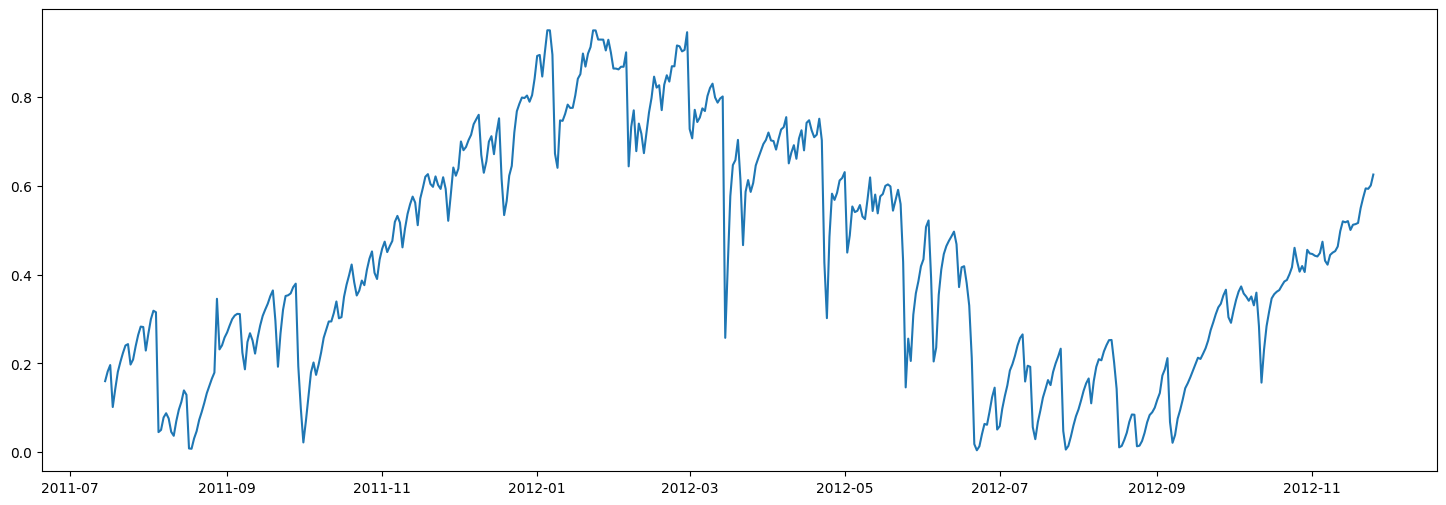

In [21]:
s = 7500
e = 8000

fig = plt.figure(figsize=(18, 6))
plt.plot(flood_prob['date'].values[s:e], flood_prob['A5030502'].values[s:e])

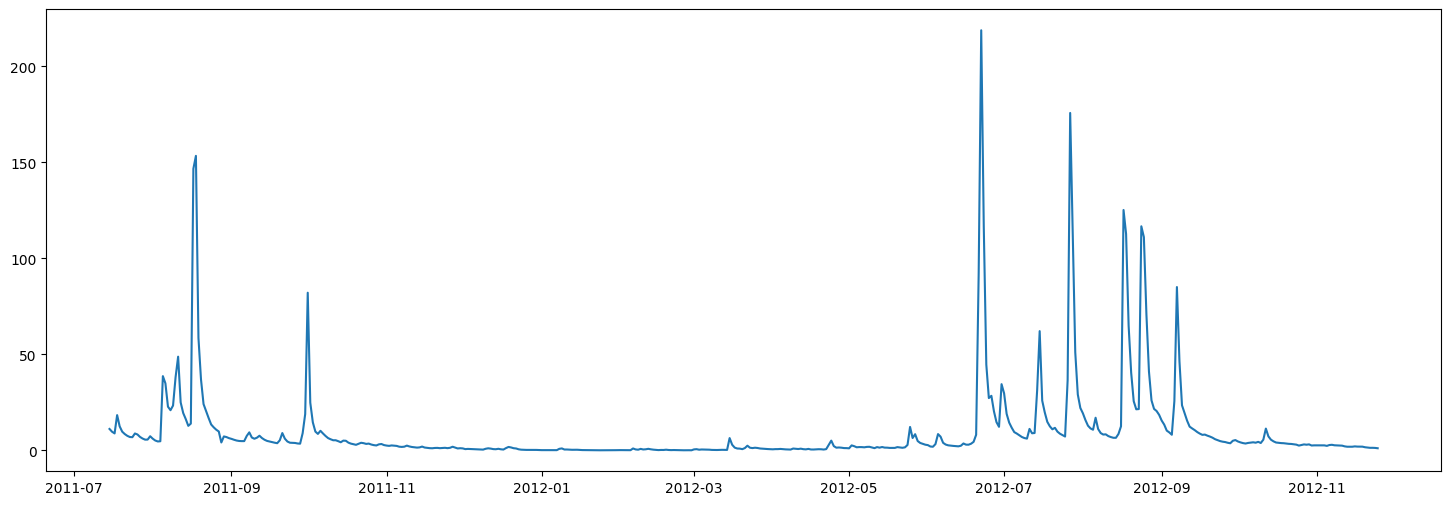

In [23]:
s = 7500
e = 8000

fig = plt.figure(figsize=(18, 6))
plt.plot(streamflow['date'].values[s:e], streamflow['A5030502'].values[s:e])